<a href="https://colab.research.google.com/github/shubhamid/IS7012/blob/master/dmbi_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title #Online Retail Customer Segmentation
Image('images.jpg', width = 600, height = 300, embed=True  ) 

### Information About Online Retail Data Set

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts and many customers of the company are wholesalers.
The dataset resource is [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Online+Retail)

### Data Dictionary 
**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter **'c'**, it indicates a cancellation.

**StockCode:** Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. Variable type is *nominal*

**Description:** Product (item) name. Variable type is *nominal*

**Quantity:** The quantities of each product (item) per transaction. Variable type is *numeric*

**InvoiceDate:** Invoice date and time. The day and time when each transaction was generated. Variable type is *numeric*

**UnitPrice:** Unit price. Product price per unit in sterling. Variable type is *numeric*

**CustomerID:** Customer number. A 5-digit integral number uniquely assigned to each customer. Variable type is *nominal*

**Country:** Country name. The name of the country where each customer resides.
Variable type is *nominal*


In [0]:
# importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import seaborn as sn
import datetime as dt
import sklearn as sc
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [0]:
# Importing the csv file
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving OnlineRetail.csv to OnlineRetail.csv


In [0]:
# Making a data frame from the csv file
data = pd.read_csv('OnlineRetail.csv', encoding = "ISO-8859-1")

In [0]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [0]:
#@title Data Set Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We checked the dataset structure here and all the variables are aligned by the info given in the data dictionary section. However, customer ID variable type looks float, so we will turn it to string type. Before doing it, we will examine unique values and NA values in each column. 

In [0]:
#Checking null values in the columns 
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [0]:
#Imputing NA Values. One thing we will try is imputing them based on invoice number. Invoice number is unique for each
#transcation. That's why it belongs to only one customer.
#Checking the null values based on customer_id
#It didnt work so we decided the remove NA's since we have enough observations to apply our clustering 

In [0]:
#Remove NA Values 
newdata = data.dropna()
newdata.isnull().sum()
newdata.shape

(406829, 8)

In [0]:
#Changing the data type
newdata['CustomerID'] = newdata['CustomerID'].astype(str)
#newdata['CustomerID'] = newdata.CustomerID.astype(int).astype(str)
newdata['InvoiceDate'] = pd.to_datetime(newdata.iloc[:,4],format='%d-%m-%Y %H:%M')
#newdata['InvoiceDate'] = pd.to_datetime(newdata.InvoiceDate, format='%m/%d/%Y %H:%M')
newdata.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [0]:
#Drop Duplicates
newdata = newdata.drop_duplicates()
newdata.shape

(401604, 8)

In [0]:
#Checking Total Unique Values in Each Column
newdata.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [0]:
#Finding in Which Country The Business Have More Transactions
most_order = newdata.groupby('Country', as_index=False)['InvoiceDate'].count().sort_values('InvoiceDate', ascending= False)
most_order.columns = ['Country', 'Total_Transactions']

Orders from mostly England. Germany, France, Erie, Spain, and Netherlands follow England respectively. However, the dataset is mostly have Eng observations from England and we will limit our customer segmentation with England 

Text(0, 0.5, 'Country')

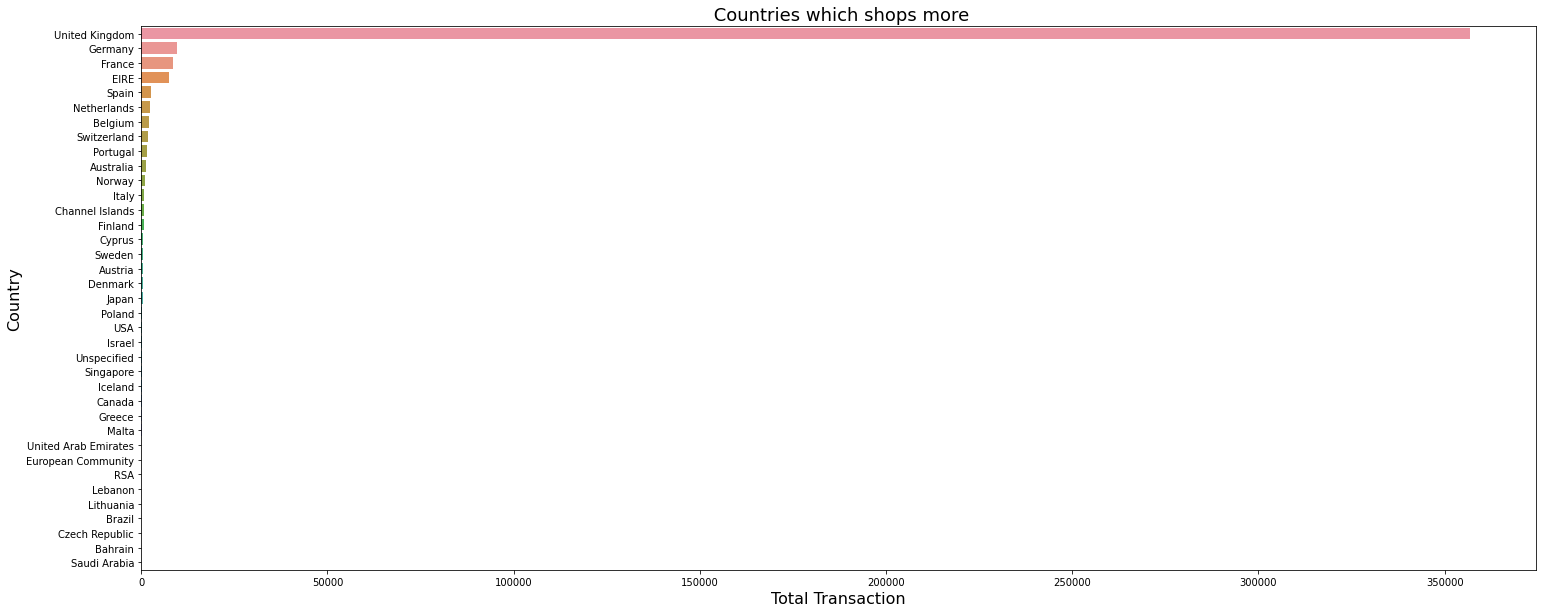

In [0]:
#@title Countries by Total Transaction Numbers
fig = plt.figure(figsize=(25, 10))
X_axis = most_order['Total_Transactions']
Y_axis = most_order['Country']
sn.barplot(X_axis, Y_axis)
plt.title(' Countries which shops more', fontsize=18)
plt.xlabel('Total Transaction', fontsize=16)
plt.ylabel('Country', fontsize=16)

In [0]:
#Creating the new data set England
england = newdata.loc[newdata['Country'] == 'United Kingdom']
england.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
newdata.describe().round(3)

,Quantity,UnitPrice
count,401604.000,401604.000
mean,12.183,3.474
std,250.283,69.764
min,-80995.000,0.000
25%,2.000,1.250
50%,5.000,1.950
75%,12.000,3.750
max,80995.000,38970.000


Since unit price has 0 values, we will remove them. However, we will keep the minus quantities because it will help us to detect the behaviour of customers who had returns. 

In [0]:
england = england[(england['UnitPrice']>0)]
england.shape

(356704, 8)

In [0]:
#Examining England Data Set
england.nunique()

InvoiceNo      19854
StockCode       3661
Description     3860
Quantity         425
InvoiceDate    18438
UnitPrice        568
CustomerID      3949
Country            1
dtype: int64

In [0]:
#Checking the number of items in each transaction 
totalitem = england.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
totalitem.columns = ['CustomerID', 'InvoiceNo', 'item_ea']
totalitem.sort_values('item_ea')

,CustomerID,InvoiceNo,item_ea
0,12346.0,541431,1
11524,15922.0,C536737,1
11521,15920.0,559511,1
11488,15906.0,C548155,1
11479,15903.0,C545847,1
...,...,...,...
4972,14096.0,573576,435
4975,14096.0,578270,442
4977,14096.0,580727,529
4976,14096.0,579196,533


This table shows that customer profile changes based on their shopping behaviour. Some customers buy frequentl with less quantities and some of them buy frequently with big amounts, and some of them shop rarely with big quantities. 

In [0]:
#Add a new variable total price
england['TotalPrice'] = england['Quantity'] * england['UnitPrice']
england.describe().round(3)

,Quantity,UnitPrice,TotalPrice
count,356704.000,356704.000,356704.000
mean,11.164,3.268,18.915
std,264.175,71.165,455.172
min,-80995.000,0.001,-168469.600
25%,2.000,1.250,3.900
50%,4.000,1.950,10.200
75%,12.000,3.750,17.700
max,80995.000,38970.000,168469.600


**CUSTOMER SEGMENTATION**
**RFM TABLE**
RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency),and how much the customer spends (monetary). In next steps, we will be using RFM table for our customer clustering process.


In [0]:
 # Compute the maximum date to know the last transaction date
max_date = max(england['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [0]:
# Creating new variable for recency
X = dt.datetime(2011,12,10)
min_date = england['InvoiceDate'].min()
min_date

Timestamp('2010-12-01 08:26:00')

In [0]:
 # Compute the difference between max date and transaction date
england['recency'] = X - england['InvoiceDate']
england.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 15:34:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 15:34:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 15:34:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 15:34:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 15:34:00


In [0]:
 # Compute last transaction date to get the recency of customers
rfm_table = england.groupby('CustomerID').agg({'InvoiceDate': lambda x: (X - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()}).sort_values('CustomerID')
rfm_table.columns = ['recency','freq','monetary']
rfm_table.sort_values('monetary').head()

,recency,freq,monetary
CustomerID,,,
17448.0,144,1,-4287.63
15369.0,144,1,-1592.49
14213.0,371,5,-1192.20
17603.0,50,15,-1165.30
15823.0,337,17,-840.76


Text(0.5, 0, 'Attributes')

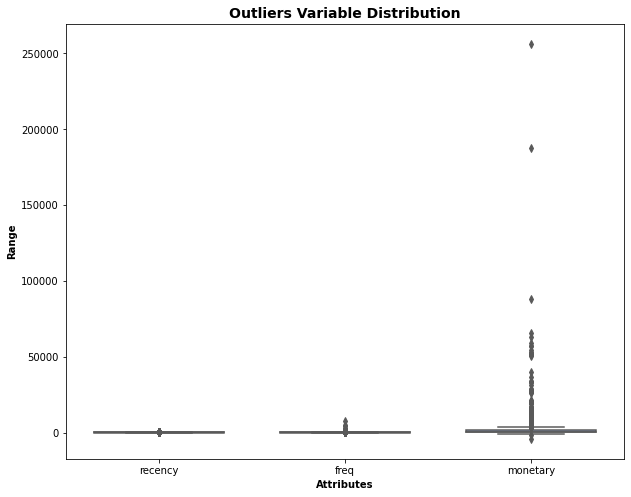

In [0]:
attributes = ['recency','freq','monetary']
plt.rcParams['figure.figsize'] = [10,8]
sn.boxplot(data = rfm_table[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [0]:
 # Removing (statistical) outliers for Monetary
Q1 = rfm_table.monetary.quantile(0.05)
Q3 = rfm_table.monetary.quantile(0.95)
IQR = Q3 - Q1
rfm_table = rfm_table[(rfm_table.monetary >= Q1 - 1.5*IQR) & (rfm_table.monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm_table.recency.quantile(0.05)
Q3 = rfm_table.recency.quantile(0.95)
IQR = Q3 - Q1
rfm_table = rfm_table[(rfm_table.recency >= Q1 - 1.5*IQR) & (rfm_table.recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm_table.freq.quantile(0.05)
Q3 = rfm_table.freq.quantile(0.95)
IQR = Q3 - Q1
rfm_table = rfm_table[(rfm_table.freq >= Q1 - 1.5*IQR) & (rfm_table.freq <= Q3 + 1.5*IQR)]

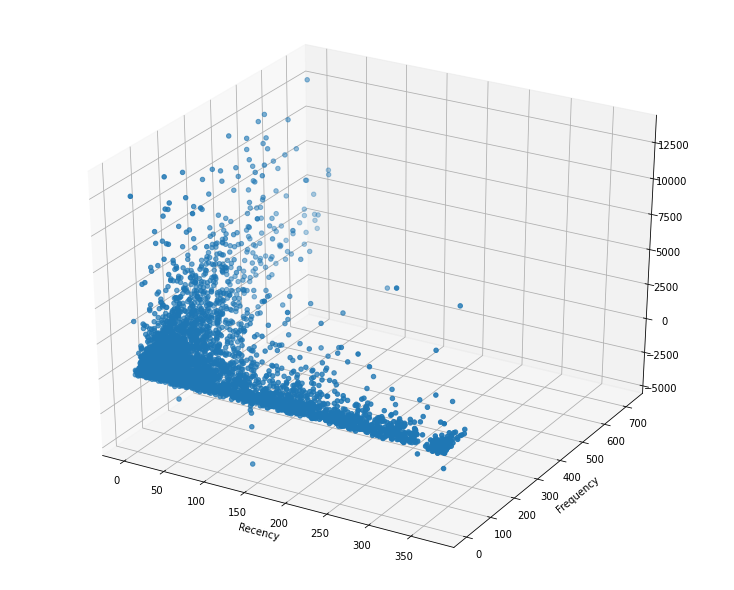

In [0]:
#3d scatter plot original data points after outlier treatment
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_table['recency'], rfm_table['freq'], rfm_table['monetary'])
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()



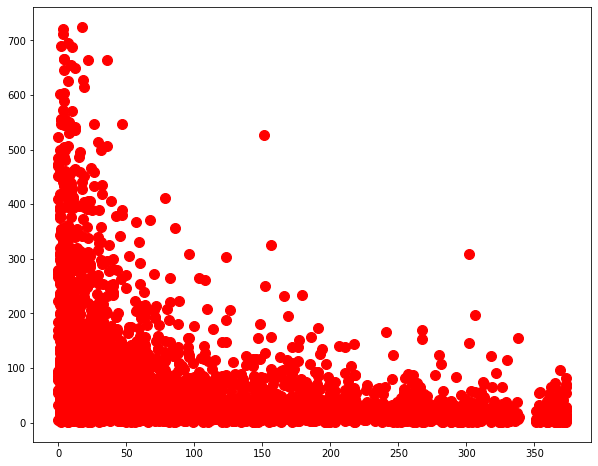

In [0]:
#RFM 2D Visualization
plt.scatter(rfm_table['recency'], rfm_table['freq'], s = 100, c = 'red',)


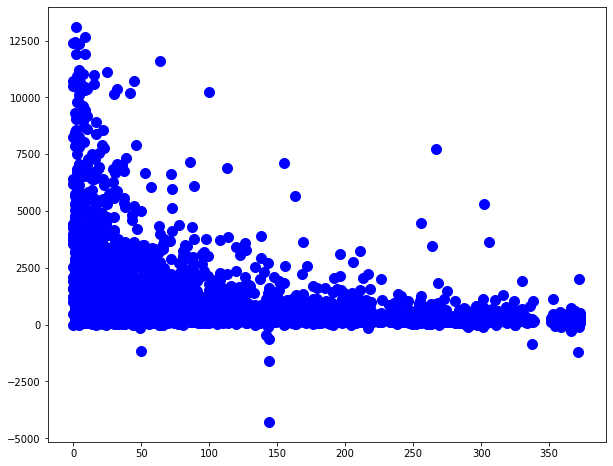

In [0]:
plt.scatter(rfm_table['recency'], rfm_table['monetary'], s = 100, c = 'blue')

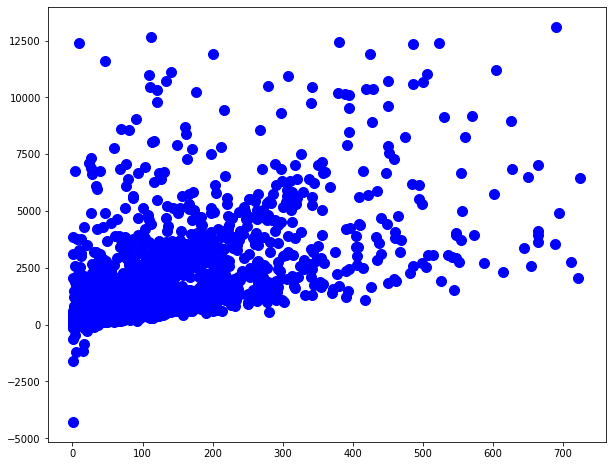

In [0]:
#RFM 2D Visualization
plt.scatter(rfm_table['freq'], rfm_table['monetary'], s = 100, c = 'blue')

Text(0, 0.5, 'Frequency')

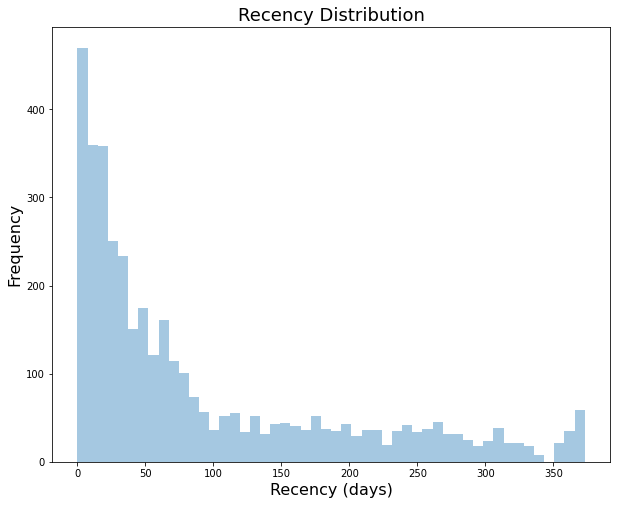

In [0]:
sn.distplot(rfm_table['recency'], kde=False, bins = 50)
plt.title('Recency Distribution', fontsize=18)
plt.xlabel('Recency (days)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


Text(0, 0.5, 'Frequency')

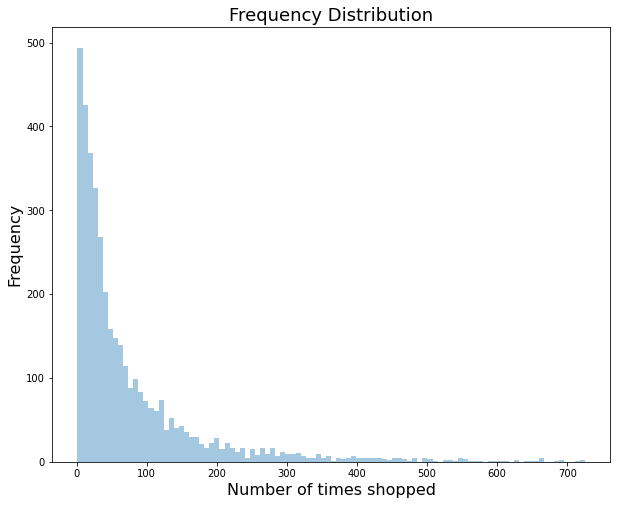

In [0]:
sn.distplot(rfm_table['freq'], kde=False, bins = 100)
plt.title('Frequency Distribution', fontsize=18)
plt.xlabel('Number of times shopped', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

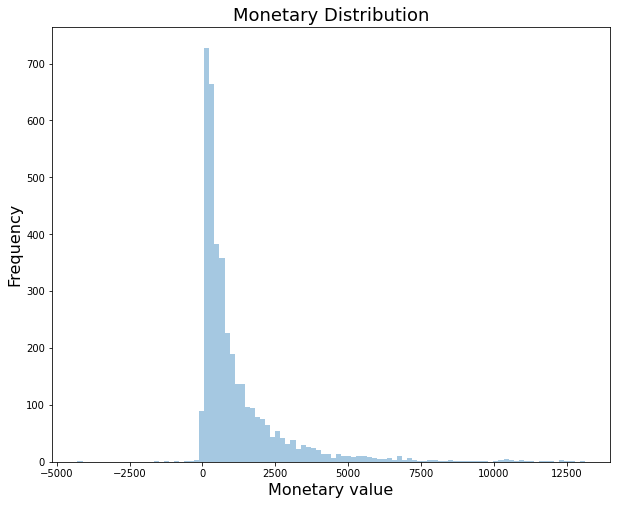

In [0]:
sn.distplot(rfm_table['monetary'], kde=False, bins = 100)
plt.title('Monetary Distribution', fontsize=18)
plt.xlabel('Monetary value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [0]:
rfm_table.describe().round(3)

,recency,freq,monetary
count,3881.000,3881.000,3881.000
mean,92.774,76.357,1202.261
std,100.455,99.924,1654.400
min,0.000,1.000,-4287.630
25%,17.000,16.000,275.400
50%,50.000,39.000,609.300
75%,147.000,95.000,1431.780
max,373.000,725.000,13110.020


In [0]:
# Rescaling the attributes
rfm_df = rfm_table[['recency', 'freq', 'monetary']]
# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape



(3881, 3)

In [0]:
# Converting normalized rfm_df_scaled array to data frame 
rfm_scaled_dfr = pd.DataFrame({'recency': rfm_df_scaled[:, 0], 'freq': rfm_df_scaled[:, 1], 'monetary': rfm_df_scaled[:, 1] })
rfm_scaled_dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   recency   3881 non-null   float64
 1   freq      3881 non-null   float64
 2   monetary  3881 non-null   float64
dtypes: float64(3)
memory usage: 91.1 KB


**Hierarchical Clustering**
Hierarchical Clustering helps us to create nested clusters organized as a hierarchical tree. One of the advantage of the hierarchical clustering, we dont have to guess cluster numbers. Cluster numbers can be deduced from the dendogram
which is a tree diagram shows sequential merges or splits. In our project we used agglomerative hierarchical cluster algorithm. Agglomerative apprach takes every single point as a cluster and then merge them based on their similarity. 
During this merge, we used euclidian distance. Also, we try different methods to select the distance between each cluster before merging to illustrate how selecting different methods can change our dendogram. Methods we tried for intercluster distance are wards, complete, and average

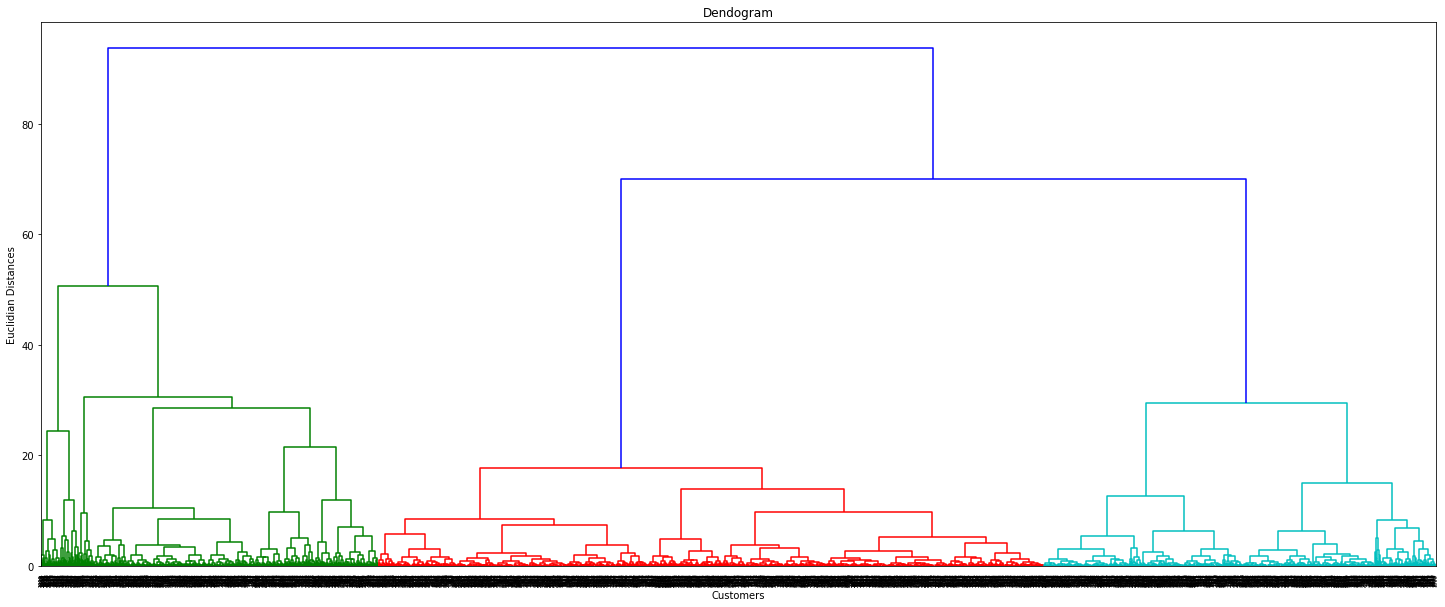

In [0]:
#If we select ward method to inter cluster distance selection
fig = plt.figure(figsize=(25, 10))
dendogram = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'ward'))
plt.title("Dendogram")
plt.xlabel("Customers")
plt.ylabel("Euclidian Distances")
plt.show()

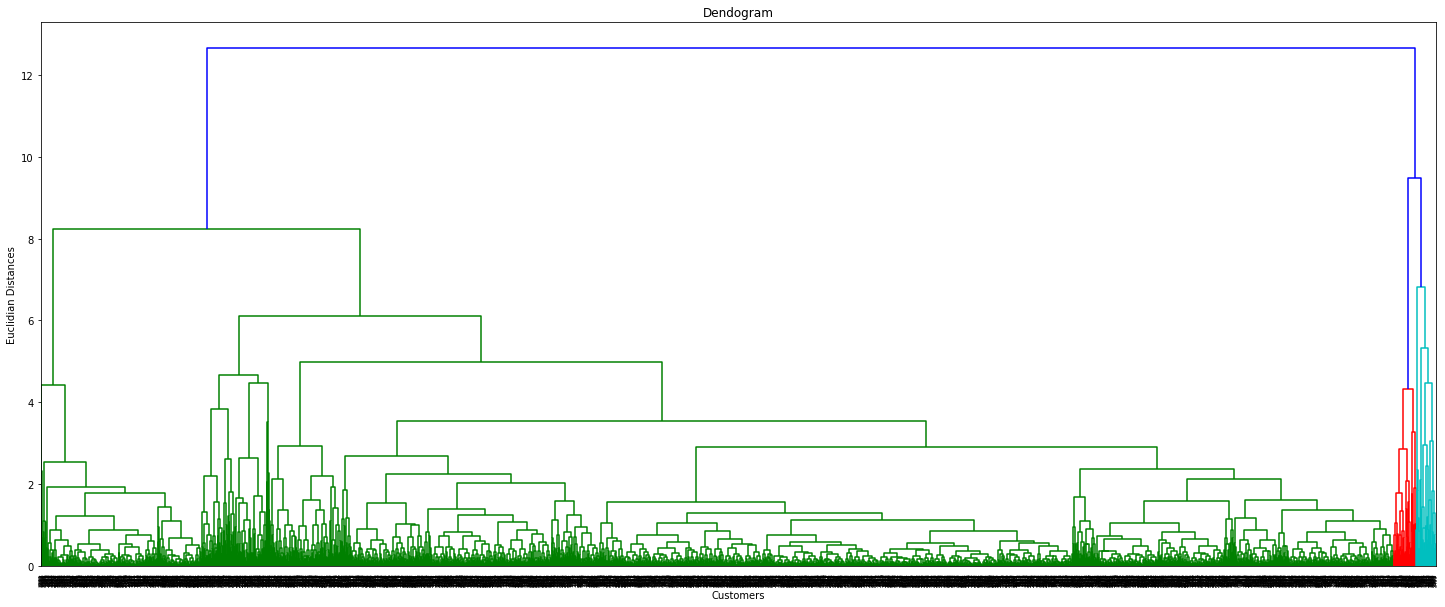

In [0]:
#If we select to inter cluster distance as max
fig = plt.figure(figsize=(25, 10))
dendogram_max = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'complete'))
plt.title("Dendogram")
plt.xlabel("Customers")
plt.ylabel("Euclidian Distances")
plt.show()

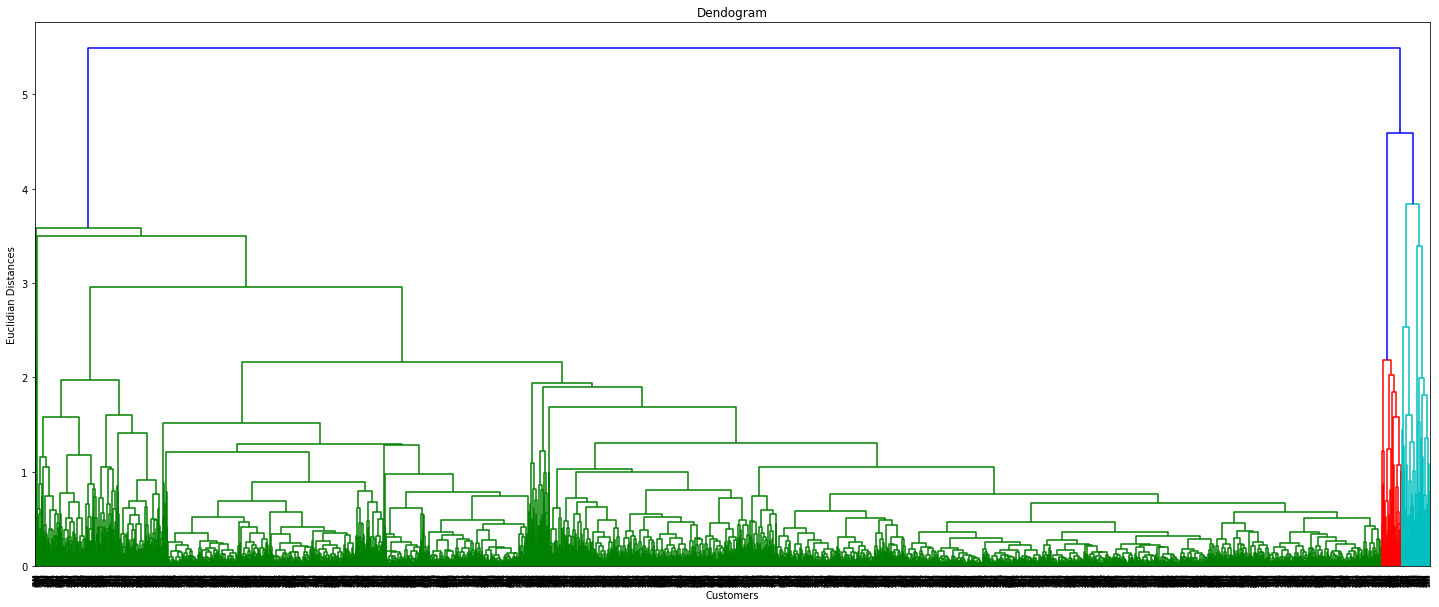

In [0]:
fig = plt.figure(figsize=(25, 10))
dendogram_average = sch.dendrogram(sch.linkage(rfm_df_scaled, method = 'average'))
plt.title("Dendogram")
plt.xlabel("Customers")
plt.ylabel("Euclidian Distances")
plt.show()

In [0]:
#Applying Algorithm to Data Set
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(rfm_df_scaled)


Among these inter cluster distance methods, we select the ward methods since it takes increase of squared error when two clusters are merged and it creates more clear dendogram for our dataset. Execution time for hierarchical clustering is 0.854. For drawing the dendogram 79.117s.

       recency      freq  monetary  Label
0     2.312049 -0.744230 -0.744230      1
1    -0.903749  0.266665  0.266665      0
2    -0.893793  1.547799  1.547799      0
3    -0.893793 -0.173725 -0.173725      2
4     1.206929 -0.704195 -0.704195      1
...        ...       ...       ...    ...
3876  1.834159 -0.664159 -0.664159      1
3877  0.868424 -0.694186 -0.694186      1
3878 -0.853969 -0.634133 -0.634133      2
3879 -0.893793  6.452142  6.452142      0
3880 -0.505508 -0.063628 -0.063628      0

[3881 rows x 4 columns]


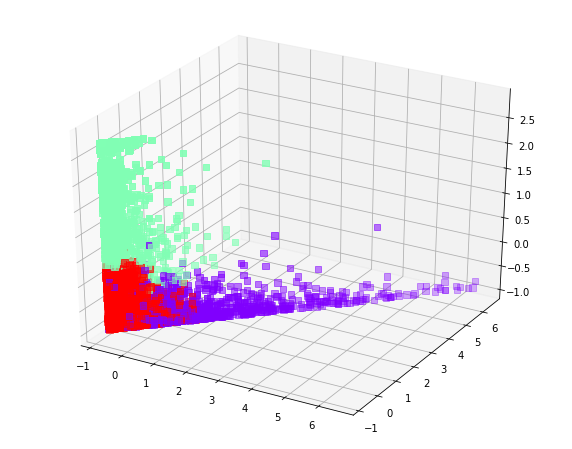

In [0]:
rfm_df_scaled_labelled= rfm_scaled_dfr
rfm_df_scaled_labelled['Label'] = y_hc
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfm_df_scaled_labelled['monetary'])
y = np.array(rfm_df_scaled_labelled['freq'])
z = np.array(rfm_df_scaled_labelled['recency'])
ax.scatter(x,y,z, marker="s", c=rfm_df_scaled_labelled["Label"], s=40, cmap="rainbow")
print(rfm_df_scaled_labelled)
 

In [0]:
silhouette_avg = silhouette_score(rfm_df_scaled, y_hc)
print("For 3 cluster, The average silhouette_score is :", silhouette_avg)

For 3 cluster, The average silhouette_score is : 0.43244931453273894


In [0]:
#Calculated silhouette score for each observation
sample_silhouette_values = silhouette_samples(rfm_df_scaled, y_hc)
sample_silhouette_values.max()

0.7674892494064572

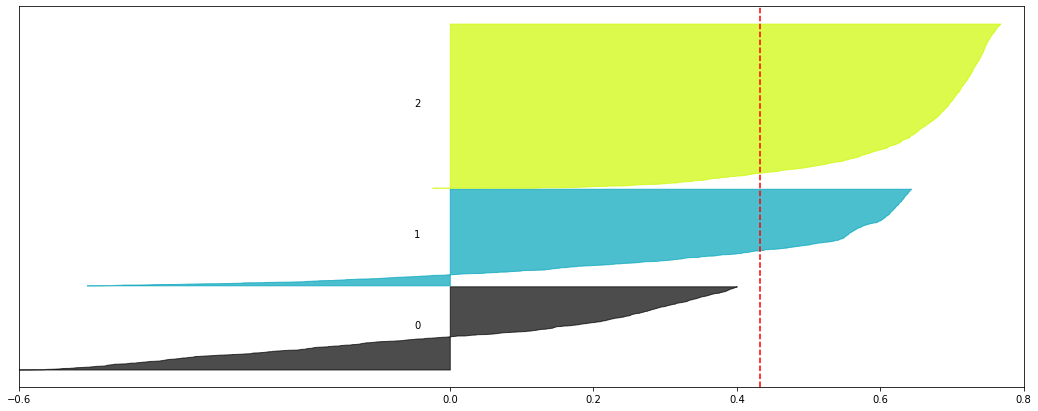

In [0]:
from matplotlib import cm
range_n_clusters = [3]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.6, 0.8])
    

y_lower = 10
for i in range (n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_hc == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.6, 0, 0.2, 0.4, 0.6, 0.8])




K-means Clustering
---

K-means is a simple and popular unsupervised learning algorithm which aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.


```
# Here is the k-means algorithm:
randomly chose k examples as initial centroids
while true:
  create k clusters by assigning each example to closest centroid
  conpute k new centroids by averaging examples in each cluster
  if centroids don't change:
    break

```



In [0]:
# Running K-means with an arbitary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
kmeans.labels_

array([1, 2, 2, ..., 0, 2, 0], dtype=int32)

**The Elbow Method** is
a fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

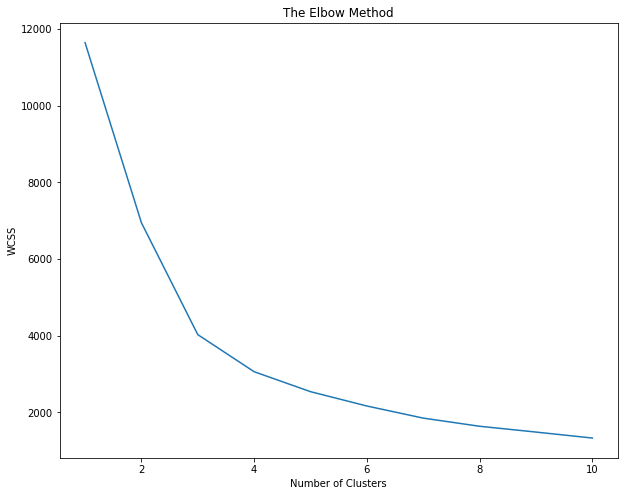

In [0]:
#Using The Elbow Method to Find Optimal Numbers of Clusters
from sklearn.cluster import KMeans
wcss = []
for i in range (1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

From the above visualization, we can see that the optimal number of clusters should be around 3. But visualizing the data alone cannot always give the right answer. Hence we demonstrate the following steps.

We now define the following:-



1.   **Distortion**: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
2.   **Inertia**: It is the sum of squared distances of samples to their closest cluster center.
We iterate the values of k from 1 to 9 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

1 : 1.3970020872539732
2 : 1.1435882175512866
3 : 0.8168596148756693
4 : 0.7098354215635244
5 : 0.6724019806518228
6 : 0.6027547378356513
7 : 0.572303642300566
8 : 0.5422150339491956
9 : 0.5282891212855647


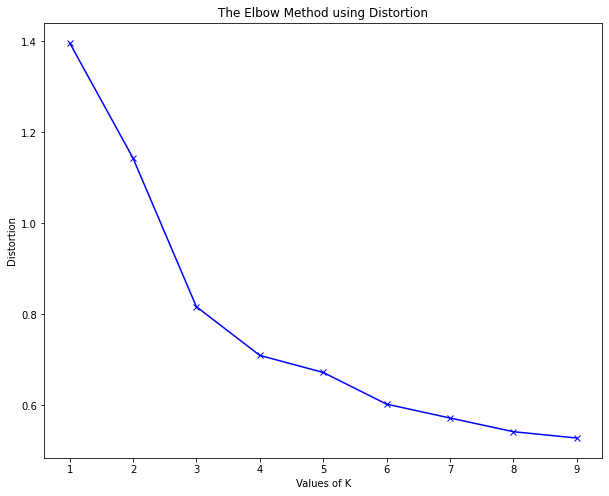

In [57]:
# Using the different values of Distortion

from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
	#Building and fitting the model 
	kmeanModel = KMeans(n_clusters=k).fit(rfm_df_scaled) 
	kmeanModel.fit(rfm_df_scaled)	 
	
	distortions.append(sum(np.min(cdist(rfm_df_scaled, kmeanModel.cluster_centers_, 
					'euclidean'),axis=1)) / rfm_df_scaled.shape[0]) 
	inertias.append(kmeanModel.inertia_) 

	mapping1[k] = sum(np.min(cdist(rfm_df_scaled, kmeanModel.cluster_centers_, 
				'euclidean'),axis=1)) / rfm_df_scaled.shape[0] 
	mapping2[k] = kmeanModel.inertia_ 


# Tabulating the results
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

# Visualizing the results
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

1 : 11642.999999999998
2 : 6944.866656248396
3 : 4026.3751427087227
4 : 3059.0897140174843
5 : 2538.1565180749417
6 : 2164.7083411580197
7 : 1848.6964425506592
8 : 1636.3560719212942
9 : 1484.3528710696098


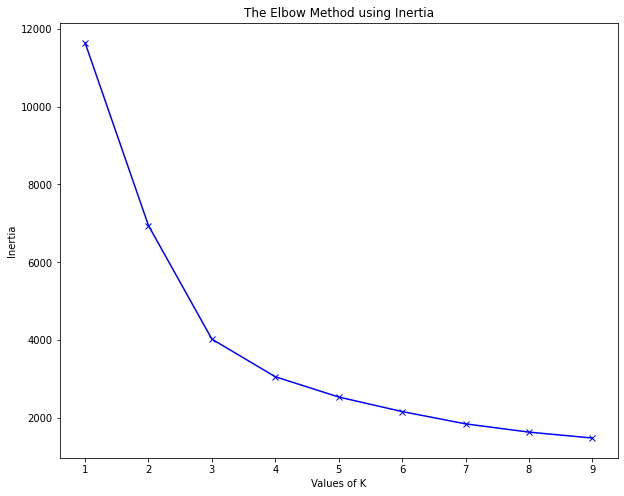

In [58]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

# Using the different values of Inertia

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [59]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5432601251196262
For n_clusters=3, the silhouette score is 0.5071629229515692
For n_clusters=4, the silhouette score is 0.47773237545286334
For n_clusters=5, the silhouette score is 0.4677236992869416
For n_clusters=6, the silhouette score is 0.4197131875359545
For n_clusters=7, the silhouette score is 0.42267247893530047
For n_clusters=8, the silhouette score is 0.40599286202654844


In [60]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
 a = kmeans.labels_

In [85]:
# assign the label
rfm_df_scaled

,recency,freq,monetary,Cluster_Id
CustomerID,,,,
12346.0,325,2,0.00,1
12747.0,2,103,4196.01,2
12749.0,3,231,3868.20,2
12820.0,3,59,942.34,0
12821.0,214,6,92.72,1
...,...,...,...,...
18280.0,277,10,180.60,1
18281.0,180,7,80.82,1
18282.0,7,13,176.60,0


In [71]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
start_time = time.time()
y_kmeans = kmeans.fit_predict(rfm_df_scaled)
time_taken = time.time() - start_time
print(time_taken)

0.10245847702026367


In [72]:
sil_kmeans=[]
s_kmeans = round(metrics.silhouette_score(rfm_df, y_hc), 4)
sil_kmeans.append(s_kmeans)
sample_silhouette_values_kmeans = silhouette_samples(rfm_df, y_kmeans)
sample_silhouette_values_kmeans.min()

NameError: ignored

In [0]:
   rfm_df_scaled_labelled_km= rfm_scaled_dfr
   rfm_df_scaled_labelled_km['Label'] = y_kmeans
   fig = plt.figure()
   ax = fig.add_subplot(111, projection='3d')
   x = np.array(rfm_df_scaled_labelled['monetary'])
   y = np.array(rfm_df_scaled_labelled['freq'])
   z = np.array(rfm_df_scaled_labelled['recency'])
   ax.scatter(x,y,z, marker="s", c=rfm_df_scaled_labelled_km["Label"], s=40, cmap="rainbow")
   print(rfm_df_scaled_labelled_km)

In [0]:
    silhouette_avg_kmeans = silhouette_score(rfm_df_scaled, y_kmeans)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg_kmeans)

In [0]:
from sklearn.cluster import KMeans

range_n_clusters_kmeans = [2,3,4]

for n_clusters in range_n_clusters_kmeans:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25, 15)
    

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.4, 0.8])
    ax1.set_ylim([0, len(rfm_df_scaled) + (n_clusters + 10) * 20])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg_kmeans = silhouette_score(rfm_df_scaled, y_kmeans)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg_kmeans)

    # Compute the silhouette scores for each sample
    sample_silhouette_values_kmeans = silhouette_samples(rfm_df_scaled, y_kmeans)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values_kmeans[y_kmeans == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, 0, 0.2, 0.4, 0.6, 0.8])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_kmeans.astype(float) / n_clusters)
    ax2.scatter(rfm_df_scaled[:, 0], rfm_df_scaled[:, 1], rfm_df_scaled[:, 2], marker='.', lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2],  marker='o',
                c="white", alpha=1, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1,
                    edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [0]:
from matplotlib import cm
range_n_clusters = [3]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.6, 0.8])
    

y_lower = 10
for i in range (n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_hc == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.6, 0, 0.2, 0.4, 0.6, 0.8])


DBSCAN

In [0]:
 rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
 rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
 rfm_df_scaled.head()
 dbscan = DBSCAN(eps=0.5, min_samples = 6)
 start_time = time.time()
 model= dbscan.fit(rfm_df_scaled)
 time_taken = time.time() - start_time
 print(time_taken)
 labels = model.labels_

In [0]:
 sample_cores = np.zeros_like(labels,dtype='bool')
 sample_cores[dbscan.core_sample_indices_] = True
 n_clusters = len(set(labels))-(1 if -1 in labels else 0)
 print(n_clusters)
 print(silhouette_score(rfm_df_scaled,labels))
 print(sample_cores)

In [0]:
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r', 'c', 'm' ] 
for k, col in zip(unique_labels, colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
    class_member_mask = (labels == k) 
  
    xy = rfm_df_scaled[class_member_mask & sample_cores] 
    plt.plot(xy['Amount'], xy['Frequency'], 'o', markerfacecolor=col, 
                                      markeredgecolor='k',  
                                      markersize=6) 
  
    xy = rfm_df_scaled[class_member_mask & ~sample_cores] 
    plt.plot(xy['Amount'], xy['Frequency'], 'o', markerfacecolor=col, 
                                      markeredgecolor='k', 
                                      markersize=6) 
  
plt.title('number of clusters: %d' %3) 
plt.show() 

In [0]:
   rfm_df_scaled_labelled= rfm_df_scaled 
   rfm_df_scaled_labelled['Label'] = labels
   fig = plt.figure()
   ax = fig.add_subplot(111, projection='3d')
   x = np.array(rfm_df_scaled_labelled['Amount'])
   y = np.array(rfm_df_scaled_labelled['Frequency'])
   z = np.array(rfm_df_scaled_labelled['Recency'])
   ax.scatter(x,y,z, marker="s", c=rfm_df_scaled_labelled['Label'], s=40, cmap="rainbow")
   print(rfm_df_scaled_labelled)